/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:14:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:14:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:14:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:14:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa


=== PPO Sequential Comparison (RAW vs HYBRID) ===
                      Model  Accuracy  Precision    Recall  F1-Score  Time (s)
1  PPO (Sequential, HYBRID)  0.993424   0.993430  0.993424  0.993426     23.66
0     PPO (Sequential, RAW)  0.989040   0.989015  0.989040  0.988992     25.35


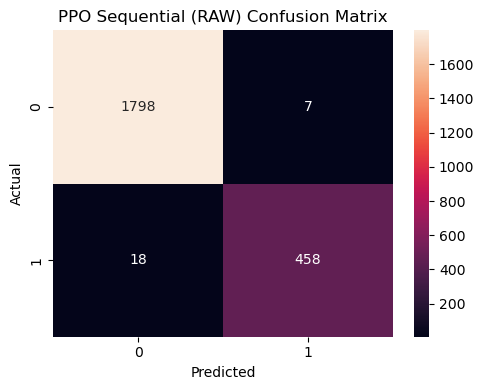

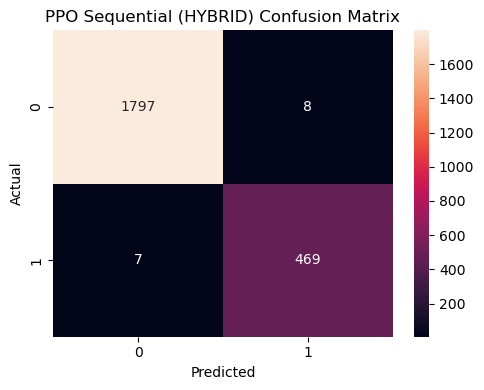


=== McNemar Test: PPO Sequential (RAW) vs PPO Sequential (HYBRID) ===
             HYBRID correct  HYBRID wrong
RAW correct            2251             5
RAW wrong                15            10
Off-diagonals b=15 (RAW wrong / HYBRID right), c=5 (RAW right / HYBRID wrong)
Statistic: 4.0500 | p-value: 0.044171 | statsmodels mcnemar (exact=False)
=> Significant at α=0.05


In [ ]:
# ============================================================
# PPO Sequential (Raw Features) vs PPO Sequential (Hybrid with DL+XGB)
# ============================================================
import time
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


import random
random.seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional, Flatten, Input
from tensorflow.keras.optimizers import Adam

file_path = os.path.join("Data", "Hybrid_Augmented_TSAFE_Features.xlsx")  # <-- change if needed


df = pd.read_excel(file_path)


if 'Plant_Destination' not in df.columns:
    if {'Plant Code', 'Destination Port'}.issubset(df.columns):
        df['Plant_Destination'] = df['Plant Code'].astype(str) + ' | ' + df['Destination Port'].astype(str)
    else:
        raise ValueError("Cannot create 'Plant_Destination' (needs 'Plant Code' & 'Destination Port').")


cat_features = ['Origin Port','Carrier','Plant Code','Destination Port','Plant_Destination']
num_features = [
    'Unit quantity','Weight','TPT',
    'TPT_per_Unit','LeadTime_Deviation','Weight_per_Unit','log_UnitQty',
    'carrier_origin_risk','route_cum_late_rate','route_bb_mean','carrier_bb_mean',
    'route_orders_last7d','route_roll10_Weight_q90',
    'congestion_trend','Weight_vsCarrierMean','seq_pos_norm',
]


cat_features = [c for c in cat_features if c in df.columns]
num_features = [c for c in num_features if c in df.columns]


if 'Ship Late Day count' not in df.columns:
    raise ValueError("'Ship Late Day count' not found.")
y = (df['Ship Late Day count'] > 0).astype(int)


if 'Order Date' not in df.columns:
    raise ValueError("'Order Date' not found (needed for sequential ordering).")
df['Order Date'] = pd.to_datetime(df['Order Date'])


X = pd.get_dummies(df[cat_features + num_features], drop_first=False)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)
def calculate_metrics(y_true, y_score_or_pred):
    arr = np.asarray(y_score_or_pred).reshape(-1)
    if set(np.unique(arr)) <= {0, 1}:
        y_pred = arr.astype(int)
    else:
        y_pred = (arr >= 0.5).astype(int)
    return {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=1),
        'Recall':    recall_score(y_true, y_pred, average='weighted', zero_division=1),
        'F1-Score':  f1_score(y_true, y_pred, average='weighted', zero_division=1)
    }

def build_dl_model(model_type, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim, 1)))
    if model_type == 'CNN':
        model.add(Conv1D(64, 2, activation='relu'))
        model.add(Flatten())
    elif model_type == 'LSTM':
        model.add(LSTM(64, activation='tanh'))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(64, activation='tanh')))
    elif model_type == 'Stacked LSTM':
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        model.add(LSTM(32, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0), loss='binary_crossentropy')
    return model

xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    param_grid={'n_estimators':[100],'max_depth':[3,5],'learning_rate':[0.1,0.05],'subsample':[0.8]},
    scoring='roc_auc', cv=3, n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_proba = xgb.best_estimator_.predict_proba(X_test)[:, 1]
X_train_dl = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_dl  = X_test_scaled.reshape(-1,  X_test_scaled.shape[1],  1)
dl_models = ['CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']
dl_outputs = {}
for m in dl_models:
    mdl = build_dl_model(m, X_train_dl.shape[1])
    mdl.fit(X_train_dl, y_train_res, epochs=10, batch_size=256, verbose=0)
    dl_outputs[m] = mdl.predict(X_test_dl, verbose=0).reshape(-1)
test_idx = X_test.index
test_frame = df.loc[test_idx, ['Order Date', 'Origin Port', 'Destination Port', 'Carrier'] + num_features].copy()
test_frame['Order Date'] = pd.to_datetime(test_frame['Order Date'])
test_frame['y'] = y_test.values.astype(int)
test_frame['xgb'] = xgb_proba
for m in dl_models:
    test_frame[m] = dl_outputs[m]
route_cols = [c for c in ['Origin Port','Destination Port','Carrier'] if c in test_frame.columns]
if len(route_cols) < 3:
    raise ValueError("Route columns missing; need Origin Port, Destination Port, Carrier.")
test_frame['route_key'] = (test_frame['Origin Port'].astype(str) + ' | ' +
                           test_frame['Destination Port'].astype(str) + ' | ' +
                           test_frame['Carrier'].astype(str))

test_frame_sorted = test_frame.sort_values('Order Date').reset_index(drop=True)
labels_sorted = test_frame_sorted['y'].values.astype(int)
route_sorted  = test_frame_sorted['route_key'].values
episodes = []
start = 0
for i in range(1, len(test_frame_sorted) + 1):
    if i == len(test_frame_sorted) or route_sorted[i] != route_sorted[i-1]:
        episodes.append(slice(start, i))
        start = i

raw_cols_available = [c for c in num_features if c in test_frame_sorted.columns]
if len(raw_cols_available) == 0:
    raise ValueError("No numeric raw features available for the raw PPO baseline.")
raw_inputs = test_frame_sorted[raw_cols_available].copy()
raw_inputs = raw_inputs.replace([np.inf, -np.inf], np.nan).fillna(raw_inputs.median(numeric_only=True))
raw_inputs = MinMaxScaler().fit_transform(raw_inputs.values.astype(np.float32)).astype(np.float32)
hybrid_cols = ['xgb','CNN','LSTM','Bi-LSTM','Stacked LSTM']
hybrid_inputs = test_frame_sorted[hybrid_cols].values.astype(np.float32)
hybrid_inputs = MinMaxScaler().fit_transform(hybrid_inputs).astype(np.float32)
class SequentialPPOEnv(gym.Env):
    """
    Observation = [base_inputs(d), time_sin, time_cos, last_K_actions(K), cum_FP, cum_FN]
    Action      = {0,1}
    Reward:
        +2 correct late (TP), +1 correct on-time (TN)
        -5 false negative, -2 false positive
        -0.01 step penalty; +0.2 bonus if FN-rate improves
    Episodes follow route continuity in time.
    """
    metadata = {"render_modes": []}

    def __init__(self, base_inputs, labels, episodes, K=5):
        super().__init__()
        self.base_inputs = base_inputs
        self.labels = labels.astype(int)
        self.episodes = episodes
        self.K = K

        self.obs_dim = base_inputs.shape[1] + 2 + K + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)

        self._ep_idx = -1
        self._indices = None
        self._t = None
        self._last_actions = None
        self._cum_fp = None
        self._cum_fn = None
        self._prev_fn_rate = 0.0

    def _time_features(self, t, T):
        pos = (t / max(T - 1, 1))
        return np.array([np.sin(2*np.pi*pos), np.cos(2*np.pi*pos)], dtype=np.float32)

    def _obs(self):
        T = len(self._indices)
        cur_idx = self._indices[self._t]
        x = self.base_inputs[cur_idx]
        time_feat = self._time_features(self._t, T)
        lastK = self._last_actions.copy()
        obs = np.concatenate([x, time_feat, lastK, np.array([self._cum_fp, self._cum_fn], dtype=np.float32)], axis=0)
        return obs.astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._ep_idx = (self._ep_idx + 1) % len(self.episodes)
        sl = self.episodes[self._ep_idx]
        self._indices = np.arange(sl.start, sl.stop, dtype=int)
        self._t = 0
        self._last_actions = np.zeros(self.K, dtype=np.float32)
        self._cum_fp = 0.0
        self._cum_fn = 0.0
        self._prev_fn_rate = 0.0
        return self._obs(), {}

    def step(self, action):
        cur_i = self._indices[self._t]
        y = self.labels[cur_i]

        if action == y:
            reward = 2.0 if y == 1 else 1.0
        else:
            if y == 1 and action == 0:
                reward = -5.0  # False Negative
                self._cum_fn += 1.0
            else:
                reward = -2.0  # False Positive
                self._cum_fp += 1.0

        reward -= 0.01  # small step penalty

        steps_so_far = float(self._t + 1)
        fn_rate = self._cum_fn / steps_so_far
        if fn_rate < self._prev_fn_rate:
            reward += 0.2
        self._prev_fn_rate = fn_rate

        self._last_actions = np.roll(self._last_actions, -1)
        self._last_actions[-1] = float(action)

        self._t += 1
        terminated = self._t >= len(self._indices)
        truncated = False

        obs = np.zeros(self.obs_dim, dtype=np.float32) if terminated else self._obs()
        return obs, float(reward), terminated, truncated, {}
def train_and_predict_seqPPO(base_inputs, labels_sorted, episodes, total_timesteps=80_000, K=5, seed=42):
    env = make_vec_env(lambda: SequentialPPOEnv(base_inputs, labels_sorted, episodes, K=K), n_envs=1)
    model = PPO("MlpPolicy", env, verbose=0, seed=seed)
    t0 = time.time()
    model.learn(total_timesteps=total_timesteps)
    learn_time = round(time.time() - t0, 2)

    # Deterministic roll-out across episodes to produce predictions in time-sorted order
    eval_env = SequentialPPOEnv(base_inputs, labels_sorted, episodes, K=K)
    obs, _ = eval_env.reset()
    preds, visited = [], 0
    while True:
        action, _ = model.predict(obs, deterministic=True)
        preds.append(int(action))
        obs, _, terminated, truncated, _ = eval_env.step(action)
        if terminated:
            visited += 1
            if visited >= len(episodes):
                break
            obs, _ = eval_env.reset()
    preds = np.array(preds[:len(labels_sorted)], dtype=int)
    return preds, learn_time
seq_raw_preds, time_raw = train_and_predict_seqPPO(raw_inputs, labels_sorted, episodes, total_timesteps=80_000, K=5, seed=42)
raw_metrics = calculate_metrics(labels_sorted, seq_raw_preds)
seq_hybrid_preds, time_hybrid = train_and_predict_seqPPO(hybrid_inputs, labels_sorted, episodes, total_timesteps=80_000, K=5, seed=42)
hybrid_metrics = calculate_metrics(labels_sorted, seq_hybrid_preds)
rows = []
rows.append({'Model':'PPO (Sequential, RAW)',    'Time (s)':time_raw,    **raw_metrics})
rows.append({'Model':'PPO (Sequential, HYBRID)', 'Time (s)':time_hybrid, **hybrid_metrics})
results_df = pd.DataFrame(rows)
print("\n=== PPO Sequential Comparison (RAW vs HYBRID) ===")
print(results_df[['Model','Accuracy','Precision','Recall','F1-Score','Time (s)']].sort_values('F1-Score', ascending=False))
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(labels_sorted, seq_raw_preds), annot=True, fmt='d')
plt.title("PPO Sequential (RAW) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(labels_sorted, seq_hybrid_preds), annot=True, fmt='d')
plt.title("PPO Sequential (HYBRID) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()
def mcnemar_from_preds(y_true, y_hat_a, y_hat_b, exact=False):
    import numpy as _np
    import pandas as _pd
    y_true = _np.asarray(y_true).astype(int)
    a = _np.asarray(y_hat_a).astype(int)
    b = _np.asarray(y_hat_b).astype(int)

    a_correct = (a == y_true)
    b_correct = (b == y_true)

    n11 = int(_np.sum(a_correct &  b_correct))
    n10 = int(_np.sum(a_correct & ~b_correct))
    n01 = int(_np.sum(~a_correct &  b_correct))
    n00 = int(_np.sum(~a_correct & ~b_correct))

    b_off = n01
    c_off = n10

    try:
        from statsmodels.stats.contingency_tables import mcnemar as sm_mcnemar
        res = sm_mcnemar([[n11, n10],[n01, n00]], exact=exact, correction=(not exact))
        stat = getattr(res, "statistic", None)
        pval = res.pvalue
        method = f"statsmodels mcnemar (exact={exact})"
    except Exception:
        from scipy.stats import chi2
        if (b_off + c_off) == 0:
            stat = 0.0; pval = 1.0
        else:
            stat = (abs(b_off - c_off) - 1.0)**2 / (b_off + c_off)
            pval = chi2.sf(stat, df=1)
        method = "manual chi-square with continuity correction (fallback)"

    table = _pd.DataFrame([[n11, n10],[n01, n00]],
                          index=['RAW correct','RAW wrong'],
                          columns=['HYBRID correct','HYBRID wrong'])
    return {'b(n01)':b_off,'c(n10)':c_off,'table':table,'statistic':stat,'pvalue':pval,'method':method}

res_cmp = mcnemar_from_preds(labels_sorted, seq_raw_preds, seq_hybrid_preds, exact=False)
print("\n=== McNemar Test: PPO Sequential (RAW) vs PPO Sequential (HYBRID) ===")
print(res_cmp['table'])
print(f"Off-diagonals b={res_cmp['b(n01)']} (RAW wrong / HYBRID right), c={res_cmp['c(n10)']} (RAW right / HYBRID wrong)")
print(f"Statistic: {res_cmp['statistic']:.4f} | p-value: {res_cmp['pvalue']:.6f} | {res_cmp['method']}")
print("=> Significant at α=0.05" if res_cmp['pvalue'] < 0.05 else "=> Not significant at α=0.05")


In [ ]:
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
kappa_raw = cohen_kappa_score(labels_sorted, seq_raw_preds)
mcc_raw = matthews_corrcoef(labels_sorted, seq_raw_preds)
kappa_hybrid = cohen_kappa_score(labels_sorted, seq_hybrid_preds)
mcc_hybrid = matthews_corrcoef(labels_sorted, seq_hybrid_preds)

print("=== Cohen's Kappa ===")
print(f"PPO Sequential (RAW):    {kappa_raw:.6f}")
print(f"PPO Sequential (HYBRID): {kappa_hybrid:.6f}")

print("\n=== Matthews Correlation Coefficient (MCC) ===")
print(f"PPO Sequential (RAW):    {mcc_raw:.6f}")
print(f"PPO Sequential (HYBRID): {mcc_hybrid:.6f}")


=== Cohen's Kappa ===
PPO Sequential (RAW):    0.966530
PPO Sequential (HYBRID): 0.980104

=== Matthews Correlation Coefficient (MCC) ===
PPO Sequential (RAW):    0.966634
PPO Sequential (HYBRID): 0.980105


In [ ]:
4